# 快速构建基于Milvus的文本-图像搜索引擎

## 相关技术介绍

### Towhere

Towhee 是一个开源的 **多模态数据处理框架**，专注于高效生成非结构化数据（如文本、图像、音频、视频等）的向量表示（Embeddings），并支持构建端到端的 AI 流水线（Pipeline）。它旨在简化从原始数据到向量化表示再到实际应用（如搜索、推荐、问答系统）的开发流程，尤其适用于需要处理多模态数据的场景。

---

### **一、Towhee 的核心功能**
1. **多模态 Embedding 生成**  
   - 支持文本、图像、音频、视频等非结构化数据的向量化。
   - 内置丰富的预训练模型（如 BERT、CLIP、ViT、ResNet、Whisper 等），可直接调用。
   - 支持自定义模型集成，灵活适配业务需求。

2. **流水线（Pipeline）构建**  
   - 提供声明式 API，通过链式调用快速组合数据处理步骤（如数据加载、预处理、模型推理、后处理等）。
   - 示例：一个图像搜索流水线可以包含 `图像解码 → 特征提取 → 向量归一化 → 存储到向量数据库`。

3. **高性能与可扩展性**  
   - 支持批量处理（Batch Processing）和 GPU 加速。
   - 分布式计算能力，适合大规模数据处理。
   - 通过算子（Operator）机制，可灵活扩展新功能。

4. **与向量数据库无缝集成**  
   - 深度兼容 Milvus、Elasticsearch、FAISS 等向量数据库，简化数据存储与检索流程。

---

## 准备
确保系统有GPU（可以使用魔搭社区提供的NoteBook），并且python版本为3.10，当前不支持python3.12

### 下载依赖

In [1]:
# 检查并安装必要的依赖包
import subprocess
import sys
import os

def install_package(package_name, version=None):
    """安装指定的包"""
    try:
        if version:
            package = f"{package_name}{version}"
        else:
            package = package_name
        
        print(f"正在安装 {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"✅ {package_name} 安装成功")
        return True
    except subprocess.CalledProcessError as e:
        print(f"❌ {package_name} 安装失败: {e}")
        return False

def check_and_install_dependencies():
    """检查并安装所有必要的依赖"""
    print("🔍 检查依赖包...")
    
    # 必要的包列表
    required_packages = [
        ("torch", ">=2.0.0"),
        ("torchvision", None),
        ("transformers", ">=4.21.0"),
        ("clip-by-openai", None),
        ("pillow", None),
        ("opencv-python", None),
        ("pandas", None),
        ("numpy", None),
        ("gradio", ">=4.0.0"),
        ("scikit-learn", None)
    ]
    
    for package_name, version in required_packages:
        try:
            # 检查包是否已安装
            __import__(package_name.replace('-', '_').split('[')[0])
            print(f"✅ {package_name} 已安装")
        except ImportError:
            print(f"❌ {package_name} 未安装，正在安装...")
            install_package(package_name, version)
    
    print("\n📦 依赖检查完成！")

# 执行依赖检查
check_and_install_dependencies()

🔍 检查依赖包...
✅ torch 已安装
✅ torchvision 已安装
✅ transformers 已安装
❌ clip-by-openai 未安装，正在安装...
正在安装 clip-by-openai...


ERROR: Cannot install clip-by-openai==0.1.0, clip-by-openai==0.1.1, clip-by-openai==0.1.1.2, clip-by-openai==0.1.1.3, clip-by-openai==0.1.1.4, clip-by-openai==0.1.1.5, clip-by-openai==1.0.1 and clip-by-openai==1.1 because these package versions have conflicting dependencies.
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts

[notice] A new release of pip is available: 23.3.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


❌ clip-by-openai 安装失败: Command '['/usr/local/bin/python', '-m', 'pip', 'install', 'clip-by-openai', '--quiet']' returned non-zero exit status 1.
❌ pillow 未安装，正在安装...
正在安装 pillow...


DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


✅ pillow 安装成功
❌ opencv-python 未安装，正在安装...
正在安装 opencv-python...


DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


✅ opencv-python 安装成功
✅ pandas 已安装
✅ numpy 已安装
✅ gradio 已安装
❌ scikit-learn 未安装，正在安装...
正在安装 scikit-learn...


DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


✅ scikit-learn 安装成功

📦 依赖检查完成！



[notice] A new release of pip is available: 23.3.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


### 环境检查

在开始之前，让我们检查一下运行环境：
- Python 版本应该是 3.8 或更高
- 如果有 GPU，确保 CUDA 可用
- 确保有足够的磁盘空间下载模型和数据

### 准备数据
数据集包含100个图像类别，每个类别中包含10张图片。数据集可通过Github下载： [Github](https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip). 

数据集包含如下三个部分：
- **train**: 候选图片目录;
- **test**: 测试图片目录;
- **reverse_image_search.csv**: csv文件，每张图片包含： ***id***, ***path***,  ***label*** ;


In [2]:
import os
import urllib.request
import zipfile
from pathlib import Path

def download_dataset():
    """下载并解压数据集"""
    
    # 检查必要的文件是否存在
    required_files = ['reverse_image_search.csv']
    required_dirs = ['train', 'test']
    
    all_exist = all(os.path.exists(f) for f in required_files) and all(os.path.exists(d) for d in required_dirs)
    
    if all_exist:
        print("✅ 数据集已存在")
        return True
    
    print("📥 开始下载数据集...")
    
    # 尝试多个下载源
    download_urls = [
        "https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip",
    ]
    
    for i, url in enumerate(download_urls):
        try:
            print(f"尝试从源 {i+1} 下载: {url}")
            
            # 下载文件
            urllib.request.urlretrieve(url, "reverse_image_search.zip")
            print("下载完成，正在解压...")
            
            # 解压文件
            with zipfile.ZipFile("reverse_image_search.zip", 'r') as zip_ref:
                zip_ref.extractall(".")
            
            # 清理压缩文件
            os.remove("reverse_image_search.zip")
            
            print("✅ 数据集下载并解压完成")
            return True
            
        except Exception as e:
            print(f"❌ 从源 {i+1} 下载失败: {e}")
            if i < len(download_urls) - 1:
                print("尝试下一个下载源...")
            continue
    
    print("❌ 所有下载源都失败了")
    print("\n📋 手动下载说明:")
    print("1. 访问: https://github.com/towhee-io/examples/releases/download/data/reverse_image_search.zip")
    print("2. 下载 reverse_image_search.zip")
    print("3. 解压到当前目录")

    return False

# 执行数据集下载
download_success = download_dataset()

if download_success:
    # 检查数据集内容
    import pandas as pd
    
    try:
        df = pd.read_csv('reverse_image_search.csv')
        print(f"\n📊 数据集信息:")
        print(f"- 总图片数量: {len(df)}")
        print(f"- 图片类别数: {df['label'].nunique()}")
        print(f"- 数据列: {list(df.columns)}")
        
        # 显示前几行数据
        print("\n📋 数据样例:")
        print(df.head())
        
    except Exception as e:
        print(f"❌ 读取数据集失败: {e}")
else:
    print("⚠️  请手动下载数据集后再继续")

✅ 数据集已存在

📊 数据集信息:
- 总图片数量: 1000
- 图片类别数: 100
- 数据列: ['id', 'path', 'label']

📋 数据样例:
   id                                     path        label
0   0  ./train/brain_coral/n01917289_1783.JPEG  brain_coral
1   1  ./train/brain_coral/n01917289_4317.JPEG  brain_coral
2   2   ./train/brain_coral/n01917289_765.JPEG  brain_coral
3   3  ./train/brain_coral/n01917289_1079.JPEG  brain_coral
4   4  ./train/brain_coral/n01917289_2484.JPEG  brain_coral


In [6]:
 # 解压文件
with zipfile.ZipFile("reverse_image_search.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

# 清理压缩文件
# os.remove("reverse_image_search.zip")

### 数据集结构说明

我们使用的数据集包含以下结构：

```
reverse_image_search/
├── reverse_image_search.csv  # 图片索引文件
├── train/                    # 训练图片目录
│   ├── class1/
│   ├── class2/
│   └── ...
└── test/                     # 测试图片目录
    ├── class1/
    ├── class2/
    └── ...
```

- **CSV文件**: 包含每张图片的ID、路径和标签信息
- **图片目录**: 按类别组织的图片文件
- **总计**: 约1000张图片，100个类别，每类10张图片

In [3]:
# 验证数据集完整性
import pandas as pd
import os
from pathlib import Path

def validate_dataset():
    """验证数据集的完整性"""
    
    if not os.path.exists('reverse_image_search.csv'):
        print("❌ CSV文件不存在，请先下载数据集")
        return False
    
    # 读取CSV文件
    df = pd.read_csv('reverse_image_search.csv')
    print(f"📊 CSV文件包含 {len(df)} 条记录")
    
    # 检查图片文件是否存在
    missing_files = []
    existing_files = 0
    
    for idx, row in df.iterrows():
        if os.path.exists(row['path']):
            existing_files += 1
        else:
            missing_files.append(row['path'])
        
        # 只检查前100个文件以节省时间
        if idx >= 100:
            break
    
    print(f"✅ 检查了前100个文件，{existing_files}个存在")
    
    if missing_files:
        print(f"⚠️  发现 {len(missing_files)} 个缺失文件")
        print("前几个缺失文件:", missing_files[:5])
    
    return len(missing_files) == 0

# 执行验证
is_valid = validate_dataset()

if is_valid:
    print("\n✅ 数据集验证通过，可以继续下一步")
    
    # 显示数据样例
    df = pd.read_csv('reverse_image_search.csv')
    print("\n📋 数据集前5行:")
    display(df.head())
    
    print(f"\n📈 数据集统计:")
    print(f"- 总记录数: {len(df)}")
    print(f"- 唯一标签数: {df['label'].nunique()}")
    print(f"- 标签分布:")
    print(df['label'].value_counts().head(10))
else:
    print("\n❌ 数据集验证失败，请检查数据完整性")

📊 CSV文件包含 1000 条记录
✅ 检查了前100个文件，101个存在

✅ 数据集验证通过，可以继续下一步

📋 数据集前5行:


,id,path,label
0,0,./train/brain_coral/n01917289_1783.JPEG,brain_coral
1,1,./train/brain_coral/n01917289_4317.JPEG,brain_coral
2,2,./train/brain_coral/n01917289_765.JPEG,brain_coral
3,3,./train/brain_coral/n01917289_1079.JPEG,brain_coral
4,4,./train/brain_coral/n01917289_2484.JPEG,brain_coral



📈 数据集统计:
- 总记录数: 1000
- 唯一标签数: 100
- 标签分布:
label
loudspeaker            10
brain_coral            10
Rhodesian_ridgeback    10
magpie                 10
measuring_cup          10
white_stork            10
safety_pin             10
basset                 10
hermit_crab            10
kit_fox                10
Name: count, dtype: int64


下面的fuction是作为text-image search的辅助
- **read_images(results)**: 通过图片ID读入图片，返回图片列表;

✅ 创建了 1000 个图片的ID映射

🧪 测试图片读取功能...
✅ 成功读取 3 张测试图片


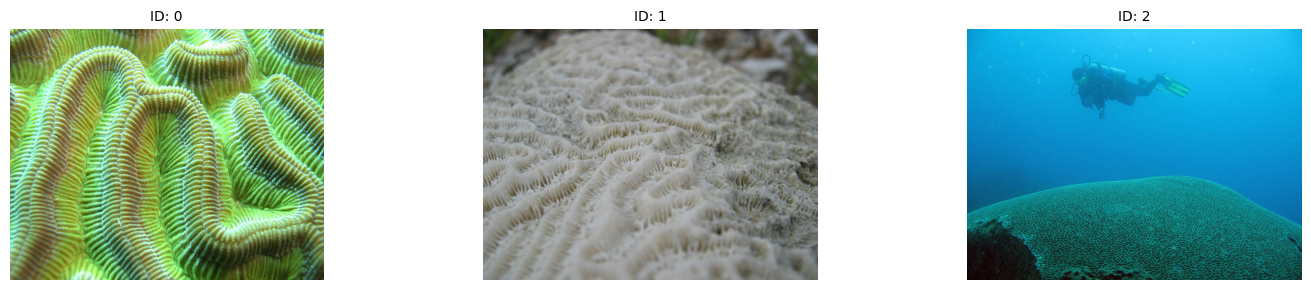

In [4]:
# 图像处理辅助函数
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 创建图片ID到路径的映射
if 'df' in locals():
    id_img = df.set_index('id')['path'].to_dict()
    print(f"✅ 创建了 {len(id_img)} 个图片的ID映射")
else:
    print("❌ 请先运行数据集验证代码")

def read_images_from_ids(image_ids):
    """根据图片ID列表读取图片"""
    images = []
    valid_paths = []
    
    for img_id in image_ids:
        if img_id in id_img:
            path = id_img[img_id]
            if os.path.exists(path):
                try:
                    # 使用PIL读取图片
                    img = Image.open(path).convert('RGB')
                    images.append(img)
                    valid_paths.append(path)
                except Exception as e:
                    print(f"⚠️  读取图片失败 {path}: {e}")
            else:
                print(f"⚠️  图片文件不存在: {path}")
        else:
            print(f"⚠️  图片ID不存在: {img_id}")
    
    return images, valid_paths

def display_images(images, titles=None, max_images=5):
    """显示图片列表"""
    if not images:
        print("没有图片可显示")
        return
    
    n_images = min(len(images), max_images)
    fig, axes = plt.subplots(1, n_images, figsize=(15, 3))
    
    if n_images == 1:
        axes = [axes]
    
    for i in range(n_images):
        axes[i].imshow(images[i])
        axes[i].axis('off')
        if titles and i < len(titles):
            axes[i].set_title(titles[i], fontsize=10)
    
    plt.tight_layout()
    plt.show()

# 测试图片读取功能
if 'df' in locals() and len(df) > 0:
    print("\n🧪 测试图片读取功能...")
    test_ids = df['id'].head(3).tolist()
    test_images, test_paths = read_images_from_ids(test_ids)
    
    if test_images:
        print(f"✅ 成功读取 {len(test_images)} 张测试图片")
        display_images(test_images, [f"ID: {test_ids[i]}" for i in range(len(test_images))])
    else:
        print("❌ 测试图片读取失败")

### 创建Milvus链接

为了防止版本冲突情况，确保grpcio的版本限制在如下的范围内，下面还引入了Milvus，是因为源码中没有启动Milvus，所以需要手动安装milvus然后启动milvus服务

In [5]:
import subprocess
import sys

# 安装 Milvus 相关依赖
try:
    print("正在安装 Milvus 依赖...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "grpcio>=1.49.1,<=1.53.0", "pymilvus", "milvus"])
    print("Milvus 依赖安装完成 ✓")
except Exception as e:
    print(f"安装失败: {e}")
    print("如果遇到版本冲突，请先卸载 pymilvus: pip uninstall pymilvus -y")
    print("然后重新安装: pip install pymilvus")

正在安装 Milvus 依赖...
Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 17.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.3/254.3 kB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 MB 11.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 128.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of pymilvus to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.3/248.3 kB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.7/241.7 kB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 MB 49.5 MB/s eta 0:00:0000:0100:01


DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


  Attempting uninstall: setuptools
    Found existing installation: setuptools 65.5.1
    Uninstalling setuptools-65.5.1:
      Successfully uninstalled setuptools-65.5.1
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.71.0
    Uninstalling grpcio-1.71.0:
      Successfully uninstalled grpcio-1.71.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.7.0 requires typer<0.10.0,>=0.3.0, but you have typer 0.16.0 which is incompatible.


Milvus 依赖安装完成 ✓



[notice] A new release of pip is available: 23.3.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


如果你已经安装了pymilvus导致了版本冲突问题，请运行如下代码，重新安装pymilvus

In [ ]:
! pip uninstall pymilvus -y

现在创建一个 `text_image_search` 的milvus collection，使用 [L2 distance metric](https://milvus.io/docs/metric.md#Euclidean-distance-L2) 和 [IVF_FLAT index](https://milvus.io/docs/index.md#IVF_FLAT)索引.

In [6]:
from milvus import default_server  
default_server.start()  

In [7]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

def create_milvus_collection(collection_name, dim):
    connections.connect("default",host='localhost', port='19530')
    
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
    FieldSchema(name='id', dtype=DataType.INT64, descrition='ids', is_primary=True, auto_id=False),
    FieldSchema(name='embedding', dtype=DataType.FLOAT_VECTOR, descrition='embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='text image search')
    collection = Collection(name=collection_name, schema=schema)

    # 为集合创建 IVF_FLAT 索引.
    index_params = {
        'metric_type':'L2',
        'index_type':"IVF_FLAT",
        'params':{"nlist":512}
    }
    collection.create_index(field_name="embedding", index_params=index_params)
    return collection

# collection = create_milvus_collection('text_image_search', 512)

## Text Image Search

使用 [Towhee](https://towhee.io/), 建立一个文本图像搜索引擎。


### 使用CLIP模型对文本和图片进行向量化


使用 [CLIP](https://openai.com/blog/clip/) 提取图像或文本的特征，该模型能够通过联合训练图像编码器和文本编码器来最大化余弦相似度，从而生成文本和图像的嵌入表示。

In [8]:
! pip install towhee

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.2/222.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 804.0/804.0 kB 15.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.7/630.7 kB 22.0 MB/s eta 0:00:00
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 2

In [9]:
from towhee import ops, pipe, DataCollection
import numpy as np

/usr/local/lib/python3.11/site-packages/towhee/runtime/operator_manager/operator_loader.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### 从魔搭社区下载模型
下面的两段代码是从魔搭社区下载模型，建议自己手动下载clip-vit-base-patch16，放到model文件夹下

In [10]:
import os
import subprocess
import sys

# 检查模型是否已存在
model_path = "./model"
if not os.path.exists(model_path) or not os.listdir(model_path):
    print("正在下载 CLIP 模型...")
    try:
        # 安装 modelscope
        subprocess.check_call([sys.executable, "-m", "pip", "install", "modelscope"])
        
        # 下载模型
        subprocess.check_call([
            "modelscope", "download", 
            "--model", "openai-mirror/clip-vit-base-patch16", 
            "--local_dir", model_path
        ])
        print("模型下载完成 ✓")
        
    except Exception as e:
        print(f"模型下载失败: {e}")
        print("请手动下载 clip-vit-base-patch16 模型到 ./model 文件夹")
        print("或者使用 Hugging Face 模型: openai/clip-vit-base-patch16")
else:
    print("模型已存在 ✓")

模型已存在 ✓


In [11]:
! pip install safetensors

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [12]:
from transformers import CLIPModel

# 直接使用 safetensors 加载（不需要 torch >= 2.6）
model = CLIPModel.from_pretrained("./model", use_safetensors=True)

# 保存为新的 safetensors 模型目录
model.save_pretrained("./model-safetensors", safe_serialization=True)

2025-09-11 17:48:53.473569: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-11 17:48:53.775135: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-11 17:48:54.763336: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.11/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first,

[2025-09-11 17:48:56,686] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)


df: /root/.triton/autotune: 没有那个文件或目录


[2025-09-11 17:48:58,757] [INFO] [logging.py:107:log_dist] [Rank -1] [TorchCheckpointEngine] Initialized with serialization = False


In [13]:
from towhee import register, ops
from towhee.operator import PyOperator
from transformers import CLIPProcessor, CLIPModel
import torch

@register
class CustomClipOperator(PyOperator):
    def __init__(self, model_path='./model'):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = CLIPModel.from_pretrained(model_path).to(self.device)
        self.processor = CLIPProcessor.from_pretrained(model_path)
        
    def __call__(self, img):
        inputs = self.processor(images=img, return_tensors="pt", padding=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        outputs = self.model.get_image_features(**inputs)
        return outputs.cpu().detach().numpy()[0]

# 在管道中使用自定义操作
p = (
    pipe.input('path')
    .map('path', 'img', ops.image_decode.cv2('rgb'))
    .map('img', 'vec', CustomClipOperator(model_path='./model'))
    .map('vec', 'vec', lambda x: x / np.linalg.norm(x))
    .output('img', 'vec')
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple


DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [14]:
# 检查 PyTorch 版本
import torch
print(torch.__version__)  # 应该 >= 2.6.0

# 检查模型加载
from transformers import CLIPModel
model = CLIPModel.from_pretrained('./model')
print("模型加载成功！")

2.3.1+cu121
模型加载成功！


In [23]:
! pip install torch>=2.6 --upgrade

DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
^C
ERROR: Operation cancelled by user


In [9]:
# PyTorch Version Fix for Towhee CLIP Issue
# Run this before importing towhee

import subprocess
import sys
import importlib

def check_and_upgrade_torch():
    """Check PyTorch version and upgrade if necessary"""
    try:
        import torch
        print(f"Current PyTorch version: {torch.__version__}")
        
        # Parse version
        version_parts = torch.__version__.split('.')
        major = int(version_parts[0])
        minor = int(version_parts[1])
        
        if major < 2 or (major == 2 and minor < 6):
            print("⚠️  PyTorch version is too old for transformers security requirements")
            print("Upgrading PyTorch to version 2.6+...")
            
            # Upgrade PyTorch
            subprocess.check_call([
                sys.executable, "-m", "pip", "install", "--upgrade",
                "torch>=2.6.0", "torchvision>=0.21.0", "torchaudio>=2.6.0",
                "--index-url", "https://download.pytorch.org/whl/cpu"
            ])
            
            print("✅ PyTorch upgraded successfully")
            print("🔄 Please restart your kernel and run this cell again")
            return False
        else:
            print("✅ PyTorch version is compatible")
            return True
            
    except ImportError:
        print("❌ PyTorch not found, installing...")
        subprocess.check_call([
            sys.executable, "-m", "pip", "install",
            "torch>=2.6.0", "torchvision>=0.21.0", "torchaudio>=2.6.0",
            "--index-url", "https://download.pytorch.org/whl/cpu"
        ])
        print("✅ PyTorch installed successfully")
        print("🔄 Please restart your kernel and run this cell again")
        return False

def upgrade_transformers():
    """Upgrade transformers to latest version"""
    try:
        subprocess.check_call([
            sys.executable, "-m", "pip", "install", "--upgrade",
            "transformers>=4.45.0"
        ])
        print("✅ Transformers upgraded successfully")
    except Exception as e:
        print(f"❌ Failed to upgrade transformers: {e}")

def install_towhee_dependencies():
    """Install Towhee and its dependencies"""
    try:
        subprocess.check_call([
            sys.executable, "-m", "pip", "install", "--upgrade",
            "towhee", "pillow", "opencv-python", "numpy"
        ])
        print("✅ Towhee dependencies installed successfully")
    except Exception as e:
        print(f"❌ Failed to install Towhee dependencies: {e}")

# Run the fixes
print("🔧 Checking and fixing PyTorch compatibility...")
if check_and_upgrade_torch():
    print("\n🔧 Upgrading transformers...")
    upgrade_transformers()
    
    print("\n🔧 Installing Towhee dependencies...")
    install_towhee_dependencies()
    
    print("\n✅ All fixes applied successfully!")
    print("You can now import towhee and run your code.")
else:
    print("\n⚠️  Please restart your kernel and run this cell again.")

🔧 Checking and fixing PyTorch compatibility...
Current PyTorch version: 2.3.1+cpu
⚠️  PyTorch version is too old for transformers security requirements
Upgrading PyTorch to version 2.6+...
Looking in indexes: https://download.pytorch.org/whl/cpu


ERROR: Operation cancelled by user


KeyboardInterrupt: 

In [15]:
p2 = (
    pipe.input('text')
    .map('text', 'vec', ops.image_text_embedding.clip(model_name='model', modality='text'))
    .map('vec', 'vec', lambda x: x / np.linalg.norm(x))
    .output('text', 'vec')
)

DataCollection(p2("A teddybear on a skateboard in Times Square.")).show()

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.0 MB/s eta 0:00:00a 0:00:010m


DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063



[notice] A new release of pip is available: 23.3.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


text,vec
A teddybear on a skateboard in Times Square.,"[-0.008685363, 0.027176848, -0.0007426147, ...] shape=(512,)"


下面是代码释意:

- `map('path', 'img', ops.image_decode.cv2_rgb('rgb'))`: 对于数据的每一行, 读取并且decode `path`下的数据然后放到 `img`中;

- `map('img', 'vec', ops.image_text_embedding.clip(model_name='model', modality='image'/'text'))`：使用 `ops.image_text_embedding.clip` 提取图像或文本的嵌入特征，该操作符来自 [Towhee hub](https://towhee.io/image-text-embedding/clip)。此操作符支持多种模型，包括 `clip_vit_base_patch16`、`clip_vit_base_patch32`、`clip_vit_large_patch14`、`clip_vit_large_patch14_336` 等。

### 将图片向量数据导入Milvus中

我们首先将已经由 `clip_vit_base_patch16` 模型处理好的图片向量化数据插入Milvus中用于后面的检索。 Towhee 提供了[method-chaining style API](https://towhee.readthedocs.io/en/main/index.html) 因此，用户可以使用这些操作符组装一个数据处理管道。这意味着用户可以根据自己的需求，将不同的操作符（如图像和文本嵌入提取操作符）组合起来，创建复杂的数据处理流程，以实现特定的功能或任务。例如，在图像检索、文本匹配或其他涉及多模态数据处理的应用场景中，通过这种方式可以灵活地构建解决方案。

In [17]:
import numpy as np
import torch
from transformers import CLIPModel, CLIPProcessor
from towhee import pipe, ops, DataCollection, register
from towhee.operator import PyOperator
from pymilvus import connections, Collection, utility, FieldSchema, CollectionSchema, DataType
import time
import csv
import os

# ==============================
# Step 0: 确保 Milvus 已连接并创建集合（先运行一次）
# ==============================


# # 创建集合
collection = create_milvus_collection('text_image_search', 512)
# collection.load()  # 加载到内存


# ==============================
# Step 1: 读取 CSV 文件
# ==============================
def read_csv(csv_path, encoding='utf-8-sig'):
    with open(csv_path, 'r', encoding=encoding) as f:
        reader = csv.DictReader(f)
        for row in reader:
            yield int(row['id']), row['path']


# ==============================
# Step 2: 自定义 CLIP 编码 Operator
# ==============================
@register(name='custom_clip_encoder')
class CustomClipOperator(PyOperator):
    def __init__(self, model_path='./model', device=0):
        self.device = "cuda" if device >= 0 and torch.cuda.is_available() else "cpu"
        print(f"Loading model on {self.device}...")
        self.model = CLIPModel.from_pretrained(model_path).to(self.device)
        self.processor = CLIPProcessor.from_pretrained(model_path)
        self.model.eval()

    def __call__(self, img_path: str):
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")

        import cv2
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError("cv2 could not decode image")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        inputs = self.processor(images=img, return_tensors="pt", padding=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model.get_image_features(**inputs)

        vec = outputs.cpu().numpy()[0]
        return vec / np.linalg.norm(vec)


# ==============================
# Step 3: 构建 Towhee Pipeline
# ==============================
p3 = (
    pipe.input('csv_file')  # 输入字段名
         .flat_map('csv_file', ('id', 'path'), read_csv)
         .map('path', 'vec', CustomClipOperator(model_path='./model', device=0))
         .output('id', 'vec')  # 输出 id 和向量
)

# ==============================
# Step 4: 执行管道并插入 Milvus
# ==============================
start = time.time()
success_count = 0

try:
    # 使用 DataCollection 来处理管道结果
    dc = DataCollection(p3('./reverse_image_search.csv'))
    
    batch_ids = []
    batch_vecs = []

    for result in dc:
        if result is None:
            continue
        id_val = result['id']
        vec = result['vec']

        batch_ids.append(id_val)
        batch_vecs.append(vec)

        # 批量插入（提升性能）
        if len(batch_ids) >= 100:  # 每 100 条插入一次
            collection.insert([batch_ids, batch_vecs])
            success_count += len(batch_ids)
            print(f"Inserted batch of {len(batch_ids)} records.")
            batch_ids, batch_vecs = [], []

    # 插入剩余数据
    if batch_ids:
        collection.insert([batch_ids, batch_vecs])
        success_count += len(batch_ids)
        print(f"Inserted final batch of {len(batch_ids)} records.")
        

except Exception as e:
    print("Pipeline execution error:", str(e))
    import traceback
    traceback.print_exc()
# ==============================
# Step 5: 统计结果
# ==============================
print(f"插入完成! 成功: {success_count} 条记录")
print(f"耗时: {time.time() - start:.2f} 秒")
print(f"集合中的实体数量: {collection.num_entities}")

Loading model on cuda...
Inserted batch of 100 records.
Inserted batch of 100 records.
Inserted batch of 100 records.
Inserted batch of 100 records.
Inserted batch of 100 records.
Inserted batch of 100 records.
Inserted batch of 100 records.
Inserted batch of 100 records.
Inserted batch of 100 records.
Inserted batch of 100 records.
插入完成! 成功: 1000 条记录
耗时: 16.27 秒
集合中的实体数量: 0


In [20]:
collection.flush()

collection.load()

In [21]:
print('Total number of inserted data is {}.'.format(collection.num_entities))

Total number of inserted data is 1000.


### 开始向量化检索

现在，候选图像的嵌入向量已经插入到 Milvus 中，我们可以对其进行最近邻查询。同样，我们使用 Towhee 来加载输入文本、计算嵌入向量，并将该向量作为 Milvus 的查询条件。由于 Milvus 仅返回图像 ID 和距离值，我们提供了一个 `read_images` 函数，根据 ID 获取原始图像并进行展示。

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple


DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


text,images
A white dog,

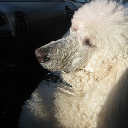
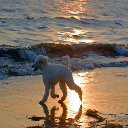
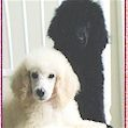
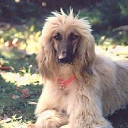
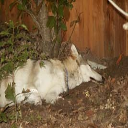

text,images
A black dog,

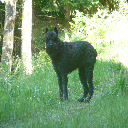
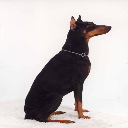
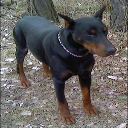
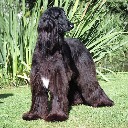
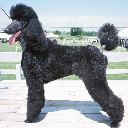

In [22]:
import pandas as pd
import cv2

def read_image(image_ids):
    df = pd.read_csv('reverse_image_search.csv')
    id_img = df.set_index('id')['path'].to_dict()
    imgs = []
    decode = ops.image_decode.cv2('rgb')
    for image_id in image_ids:
        path = id_img[image_id]
        imgs.append(decode(path))
    return imgs


p4 = (
    pipe.input('text')
    .map('text', 'vec', ops.image_text_embedding.clip(model_name='model', modality='text'))
    .map('vec', 'vec', lambda x: x / np.linalg.norm(x))
    .map('vec', 'result', ops.ann_search.milvus_client(host='127.0.0.1', port='19530', collection_name='text_image_search', limit=5))
    .map('result', 'image_ids', lambda x: [item[0] for item in x])
    .map('image_ids', 'images', read_image)
    .output('text', 'images')
)

DataCollection(p4("A white dog")).show()
DataCollection(p4("A black dog")).show()

## 使用Gradio构建一个应用

In [23]:
search_pipeline = (
    pipe.input('text')
    .map('text', 'vec', ops.image_text_embedding.clip(model_name='model', modality='text'))
    .map('vec', 'vec', lambda x: x / np.linalg.norm(x))
    .map('vec', 'result', ops.ann_search.milvus_client(host='127.0.0.1', port='19530', collection_name='text_image_search', limit=5))
    .map('result', 'image_ids', lambda x: [item[0] for item in x])
    .output('image_ids')
)

def search(text):
    df = pd.read_csv('reverse_image_search.csv')
    id_img = df.set_index('id')['path'].to_dict()
    imgs = []
    image_ids = search_pipeline(text).to_list()[0][0]
    return [id_img[image_id] for image_id in image_ids]


在高版本的gradio中，已经不支持gradio.inputs.xxx和gradio.outputs.xxx，可直接使用gradio.TextBox或者gradio.Image
你可以使用如下代码更新一下你的gradio

In [ ]:
! pip install --upgrade gradio

In [24]:
import gradio

interface = gradio.Interface(search, 
                             gradio.Textbox(lines=1),
                             [gradio.Image(type="filepath", label=None) for _ in range(5)]
                            )
# 记得搜索的时候用英文！比如我要搜索蓝色的天空，那我就输入blue sky
interface.launch(inline=True, share=True)

* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Missing file: /root/.cache/huggingface/gradio/frpc/frpc_linux_amd64_v0.3. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.3/frpc_linux_amd64
2. Rename the downloaded file to: frpc_linux_amd64_v0.3
3. Move the file to this location: /root/.cache/huggingface/gradio/frpc


Created dataset file at: .gradio/flagged/dataset2.csv
